In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
#print(os.listdir("..input"))

from scipy.ndimage import affine_transform
from PIL import Image as pil_image
from PIL import ImageDraw as pil_draw
from PIL import Image

from keras.models import load_model
from keras.preprocessing.image import img_to_array, array_to_img
import keras.backend as K

from tqdm import tqdm
import matplotlib.pyplot as plt


In [18]:
TRAIN_PATH = "train"
TEST_PATH = "test"
MODEL_PATH = "cropping.model"

In [19]:
model = load_model(MODEL_PATH)

In [21]:
train_paths = [img for img in os.listdir(TRAIN_PATH)]
test_paths = [img for img in os.listdir(TEST_PATH)]

In [22]:
img_shape = (128,128,1)
anisotropy = 2.15

In [23]:
def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

In [24]:
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)

In [25]:
def read_raw_image(p):
    return pil_image.open(p)

In [26]:
def read_for_validation(x):
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x, t

In [27]:
def coord_transform(list, trans):
    result = []
    for x,y in list:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result

In [28]:
def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

In [29]:
def make_bbox(p):
    raw = read_array(p)
    width, height = raw.shape[1], raw.shape[0]
    img,trans         = read_for_validation(raw)
    a                 = np.expand_dims(img, axis=0)
    x0, y0, x1, y1    = model.predict(a).squeeze()
    (u0, v0),(u1, v1) = coord_transform([(x0,y0),(x1,y1)], trans)
    bbox = [max(u0,0), max(v0,0), min(u1,width), min(v1,height)]
    if bbox[0] >= bbox[2] or bbox[1] >= bbox[3]:
        bbox = [0,0,width,height]
    return bbox

In [30]:
def transform_coordinate(coords, trans):
    result = []
    for x,y in coords:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result

In [31]:
bbox_df = pd.DataFrame(columns=['Image','x0','y0','x1','y1']).set_index('Image')

In [32]:
for img in tqdm(train_paths):
    bbox_df.loc[img] = make_bbox(TRAIN_PATH+"/"+img)

100%|████████████████████████████████████████████████████████████████████████████| 25361/25361 [19:44<00:00, 21.41it/s]


In [33]:
for img in tqdm(test_paths):
    bbox_df.loc[img] = make_bbox(TEST_PATH+"/"+img)

100%|██████████████████████████████████████████████████████████████████████████████| 7960/7960 [06:38<00:00, 19.99it/s]


In [35]:
bbox_df.to_csv(path_or_buf='bouncing_box.csv')

In [36]:
from numpy.linalg import inv as mat_inv


In [37]:
img_name = "32318c344.jpg"
img = pil_image.open(TRAIN_PATH+"/"+img_name)

In [38]:
print(img.size)

(1800, 700)


In [39]:
x0,y0,x1,y1 = bbox_df.loc[img_name]
print("Original BB Coordinates",x0,y0,x1,y1)

Original BB Coordinates 19 95 1745 517


In [40]:
imgArr,trans = read_for_validation(read_array(TRAIN_PATH+"/"+img_name))
(xt0,yt0),(xt1,yt1) = transform_coordinate([(x0,y0),(x1,y1)],mat_inv(trans))
print("New BB Coordinates",xt0,yt0,xt1,yt1)

New BB Coordinates 1 25 124 89


In [47]:
imgNew = array_to_img(imgArr)
imgNew = imgNew.convert('RGB')

In [48]:
imgDraw = pil_draw.Draw(imgNew)
imgDraw.rectangle([(xt0,yt0),(xt1,yt1)],outline='red')

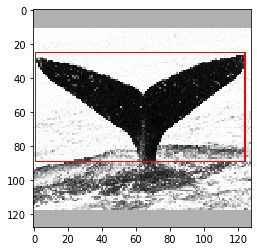

In [49]:
plt.imshow(imgNew)

In [57]:
imgNew.save("train/" + img_name)

In [60]:
damn = pd.read_csv("train.csv")

In [68]:
for i in damn["Image"]:
    img_name = i
    img = pil_image.open(TRAIN_PATH+"/"+img_name)
    x0,y0,x1,y1 = bbox_df.loc[img_name]
    imgArr,trans = read_for_validation(read_array(TRAIN_PATH+"/"+img_name))
    (xt0,yt0),(xt1,yt1) = transform_coordinate([(x0,y0),(x1,y1)],mat_inv(trans))
    imgNew = array_to_img(imgArr)
    imgNew = imgNew.convert('RGB')
    imgDraw = pil_draw.Draw(imgNew)
    imgDraw.rectangle([(xt0,yt0),(xt1,yt1)],outline='red')
    imgNew.save("new_train/" + img_name)